<a href="https://colab.research.google.com/github/sachsac/teaching_data/blob/main/TA_Hours_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install openpyxl==3.0.0

In [2]:
from sklearn import set_config
set_config(display='diagram')

# Imports/Data Upload

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score
plt.style.use('seaborn')

In [37]:
#from https://stackoverflow.com/questions/26521266/using-pandas-to-pd-read-excel-for-multiple-worksheets-of-the-same-workbook
sheet_lst_wanted = ["AAS","BAS"] # tab names from Excel

### import and compile data ###
    
# read all sheets from list into an ordered dictionary    
dict_temp = pd.read_excel('/content/drive/MyDrive/Work/Independent Projects/TA work/TA helping.xlsx', sheet_name= sheet_lst_wanted)

# concatenate the ordered dict items into a dataframe
data = pd.concat(dict_temp, axis=0, ignore_index=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Student                    141 non-null    object        
 1   Cohort                     141 non-null    object        
 2   Stack                      141 non-null    object        
 3   Time                       141 non-null    object        
 4   Date                       141 non-null    datetime64[ns]
 5   Day of week                141 non-null    object        
 6   Time (Pacific)             141 non-null    object        
 7   Pacific Time (Military)    141 non-null    int64         
 8   Off Hours Request? Y/N     141 non-null    object        
 9   End Time                   42 non-null     object        
 10  End Time Pacific           42 non-null     object        
 11  End Time (Military)        42 non-null     float64       
 12  Total Ti

In [14]:
df = data[['Cohort', 'Stack','Time (Pacific)', 'Date', 'Day of week', 'Pacific Time (Military)', 'Off Hours Request? Y/N']]
#exclude the end times as they do not apply to first contact
#only needed one of the Time columns since they represent the same thing
df.head()

,Cohort,Stack,Time (Pacific),Date,Day of week,Pacific Time (Military),Off Hours Request? Y/N
0,2/21,Data Fundamentals,11:08:00,2022-03-01,Tue,1108,Yes
1,11/29,Advanced Machine Learning,17:50:00,2022-03-01,Tue,1750,No
2,1/24,Machine Learning,18:04:00,2022-03-01,Tue,1804,No
3,11/29,Advanced Machine Learning,18:47:00,2022-03-01,Tue,1847,No
4,11/29,Advanced Machine Learning,14:06:00,2022-03-02,Wed,1406,Yes


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Cohort                   141 non-null    object        
 1   Stack                    141 non-null    object        
 2   Time (Pacific)           141 non-null    object        
 3   Date                     141 non-null    datetime64[ns]
 4   Day of week              141 non-null    object        
 5   Pacific Time (Military)  141 non-null    int64         
 6   Off Hours Request? Y/N   141 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 7.8+ KB


#Classification Model


## Can we predict if a student will contact after hours vs during hours?
(A Classification Problem)
Although the Regression Problem was unable to be tackled using this data, can it more reliably help with a classification question?

In [9]:
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [10]:
df.isnull().sum()

Cohort                     0
Stack                      0
Time (Pacific)             0
Date                       0
Day of week                0
Pacific Time (Military)    0
Off Hours Request? Y/N     0
dtype: int64

In [15]:
#although it is the same data set, we need to redo our train test split and preprocessing steps
X = df.drop(columns =['Off Hours Request? Y/N', 'Time (Pacific)', 'Pacific Time (Military)']) #Times/ Time in Military mostly used for analysis purposes
y = df['Off Hours Request? Y/N']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [17]:
#code to check the split of our variables
unique, counts = np.unique(y_train, return_counts=True)
print('Counts of each class in Training:', dict(zip(unique, counts)))
unique, counts = np.unique(y_test, return_counts=True)
print('Counts of each class in Test:', dict(zip(unique, counts)))

Counts of each class in Training: {'No': 63, 'Yes': 42}
Counts of each class in Test: {'No': 22, 'Yes': 14}


In [18]:
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')
scaler = StandardScaler()
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [19]:
num_tuple = (scaler, num_selector)
cat_tuple = (encoder, cat_selector)

In [20]:
col_trans = make_column_transformer(num_tuple, cat_tuple)

In [21]:
X_train = col_trans.fit_transform(X_train)
X_test = col_trans.transform(X_test)

In [22]:
print('Baseline Training Accuracy:')
print(y_train.value_counts(normalize=True))
print()
print('Baseline Testing Accuracy:')
print(y_test.value_counts(normalize=True))  

Baseline Training Accuracy:
No     0.6
Yes    0.4
Name: Off Hours Request? Y/N, dtype: float64

Baseline Testing Accuracy:
No     0.611111
Yes    0.388889
Name: Off Hours Request? Y/N, dtype: float64


Logistic Regression Train Performance
              precision    recall  f1-score   support

          No       0.82      0.94      0.87        63
         Yes       0.88      0.69      0.77        42

    accuracy                           0.84       105
   macro avg       0.85      0.81      0.82       105
weighted avg       0.84      0.84      0.83       105

Logistic Regression Test Performance
              precision    recall  f1-score   support

          No       0.68      0.95      0.79        22
         Yes       0.80      0.29      0.42        14

    accuracy                           0.69        36
   macro avg       0.74      0.62      0.61        36
weighted avg       0.73      0.69      0.65        36



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


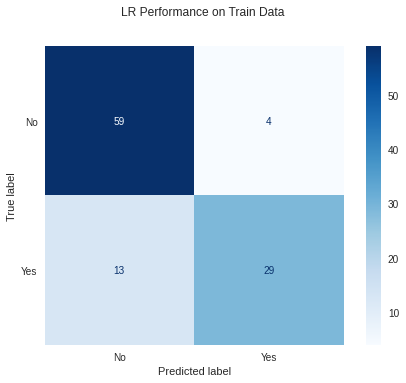

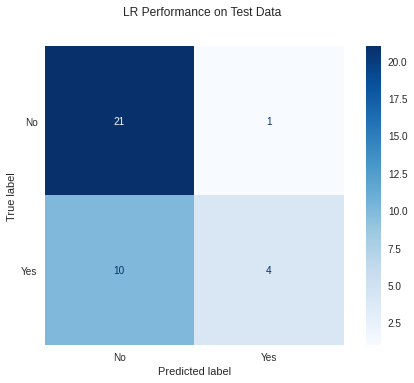

In [29]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('Logistic Regression Train Performance')
print(metrics.classification_report(y_train, lr.predict(X_train)))
print('Logistic Regression Test Performance')
print(metrics.classification_report(y_test, y_pred))
display(plot_confusion_matrix(lr, X_train, y_train, cmap = 'Blues', values_format = 'd'))
plt.grid(alpha=0)
plt.suptitle('LR Performance on Train Data')
plot_confusion_matrix(lr, X_test, y_test, cmap = 'Blues', values_format = 'd')
plt.grid(alpha=0)
plt.suptitle('LR Performance on Test Data');
#the confusion matrix shows us visually what the classification report says
#however, it also really shows us how small this data set is

XGB Train Performance
              precision    recall  f1-score   support

          No       0.85      0.90      0.88        63
         Yes       0.84      0.76      0.80        42

    accuracy                           0.85       105
   macro avg       0.85      0.83      0.84       105
weighted avg       0.85      0.85      0.85       105

XGB Test Performance
              precision    recall  f1-score   support

          No       0.67      0.73      0.70        22
         Yes       0.50      0.43      0.46        14

    accuracy                           0.61        36
   macro avg       0.58      0.58      0.58        36
weighted avg       0.60      0.61      0.60        36



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


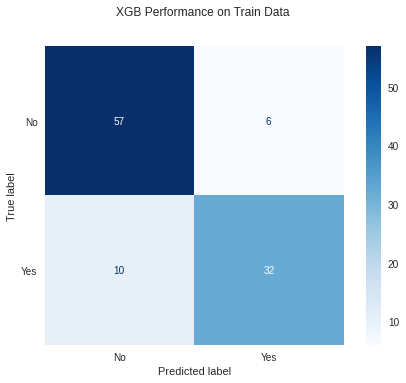

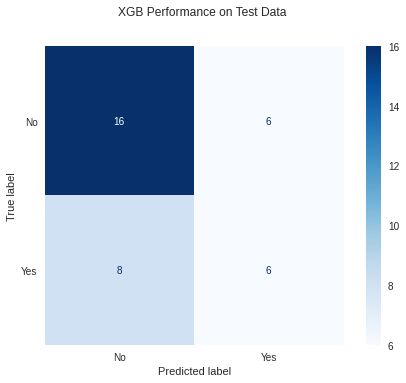

In [30]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
y_pred3 = xgb.predict(X_test)

#Classification Reports
print('XGB Train Performance')
print(metrics.classification_report(y_train,xgb.predict(X_train)))
print('XGB Test Performance')
print(metrics.classification_report(y_test, y_pred3))

#Confusion Matrices
plot_confusion_matrix(xgb, X_train, y_train, cmap = 'Blues', values_format = 'd')
plt.grid(alpha=0)
plt.suptitle('XGB Performance on Train Data')

plot_confusion_matrix(xgb, X_test, y_test, cmap = 'Blues', values_format = 'd')
plt.grid(alpha=0)
plt.suptitle('XGB Performance on Test Data');
#the confusion matrix shows us visually what the classification report says
#however, it also really shows us how small this data set is

KNN Train Performance
              precision    recall  f1-score   support

          No       0.78      0.97      0.87        63
         Yes       0.93      0.60      0.72        42

    accuracy                           0.82       105
   macro avg       0.85      0.78      0.79       105
weighted avg       0.84      0.82      0.81       105

KNN Test Performance
              precision    recall  f1-score   support

          No       0.69      1.00      0.81        22
         Yes       1.00      0.29      0.44        14

    accuracy                           0.72        36
   macro avg       0.84      0.64      0.63        36
weighted avg       0.81      0.72      0.67        36



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


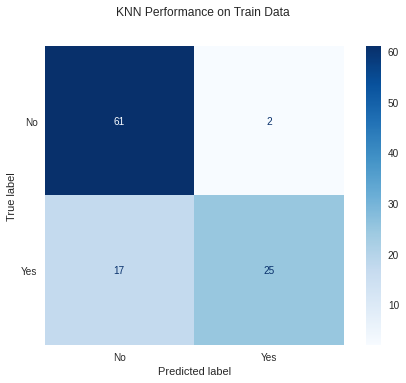

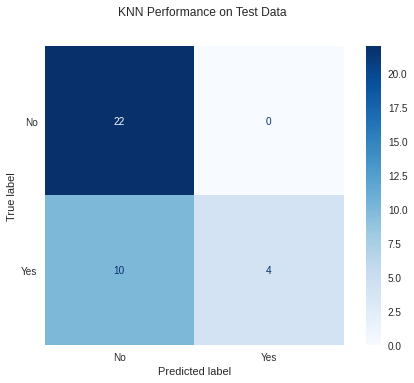

In [32]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred2 = knn.predict(X_test)

#classification reports
print('KNN Train Performance')
print(metrics.classification_report(y_train, knn.predict(X_train)))
print('KNN Test Performance')
print(metrics.classification_report(y_test, y_pred2))

#conf matrices
plot_confusion_matrix(knn, X_train, y_train, cmap = 'Blues', values_format = 'd')
plt.grid(alpha=0)
plt.suptitle('KNN Performance on Train Data')

plot_confusion_matrix(knn, X_test, y_test, cmap = 'Blues', values_format = 'd')
plt.grid(alpha=0)
plt.suptitle('KNN Performance on Test Data');

## Conclusion

The data we have does not reliably predict on or off hour contact for test data

# Regression

## Time Spent With Students Analysis

In [33]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Cohort                     141 non-null    object        
 1   Stack                      141 non-null    object        
 2   Date                       141 non-null    datetime64[ns]
 3   Day of week                141 non-null    object        
 4   Time (Pacific)             141 non-null    object        
 5   Pacific Time (Military)    141 non-null    int64         
 6   Total Time helping (mins)  42 non-null     float64       
 7   End Time Pacific           42 non-null     object        
 8   End Time (Military)        42 non-null     float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 10.0+ KB


In [83]:
data = data[['Cohort', 'Stack', 'Date', 'Day of week', 'Time (Pacific)', 'Pacific Time (Military)','Total Time helping (mins)']] #do not include end times as those were used for calculations of total time helped

data.head() #what do we have? what should we drop?

,Cohort,Stack,Date,Day of week,Time (Pacific),Pacific Time (Military),Total Time helping (mins)
0,2/21,Data Fundamentals,2022-03-01,Tue,11:08:00,1108,NaN
1,11/29,Advanced Machine Learning,2022-03-01,Tue,17:50:00,1750,NaN
2,1/24,Machine Learning,2022-03-01,Tue,18:04:00,1804,NaN
3,11/29,Advanced Machine Learning,2022-03-01,Tue,18:47:00,1847,NaN
4,11/29,Advanced Machine Learning,2022-03-02,Wed,14:06:00,1406,NaN


In [84]:
time_nulls = data['Total Time helping (mins)'].isna()
timeregdata = data[~time_nulls].drop(columns = ['Time (Pacific)', 'Date'])

In [85]:
timeregdata.head()

,Cohort,Stack,Day of week,Pacific Time (Military),Total Time helping (mins)
8,2/21,Data Fundamentals,Wed,1838,67.0
17,2/21,Data Fundamentals,Tue,1726,86.0
18,1/24,Machine Learning,Wed,645,23.0
19,2/21,Data Fundamentals,Wed,839,6.0
20,2/21,Data Fundamentals,Wed,1428,24.0


In [86]:
timeregdata['Total Time helping (mins)'] = timeregdata['Total Time helping (mins)'].astype(int)
timeregdata.dtypes

Cohort                       object
Stack                        object
Day of week                  object
Pacific Time (Military)       int64
Total Time helping (mins)     int64
dtype: object

In [87]:
X = timeregdata.drop(columns='Total Time helping (mins)')
y = timeregdata['Total Time helping (mins)']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [88]:
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')
scaler = StandardScaler()
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
num_tuple = (scaler, num_selector)
cat_tuple = (encoder, cat_selector)

In [89]:
col_trans = make_column_transformer(num_tuple, cat_tuple)

In [90]:
lr = LinearRegression()
lr_pipe =make_pipeline(col_trans, lr)
lr_pipe.fit(X_train, y_train)
print('Linear Regression Training Score:', r2_score(y_train, lr_pipe.predict(X_train)))
print('Linear Regression Testing Score:', r2_score(y_test, lr_pipe.predict(X_test)))
print('Linear Regression RMSE Training:', np.sqrt(mean_squared_error(y_train, lr_pipe.predict(X_train))))
print('Linear Regression RMSE Testing:', np.sqrt(mean_squared_error(y_test, lr_pipe.predict(X_test))))

Linear Regression Training Score: 0.3795070614955157
Linear Regression Testing Score: 0.01095567697881894
Linear Regression RMSE Training: 33.82670243956433
Linear Regression RMSE Testing: 45.262150540357


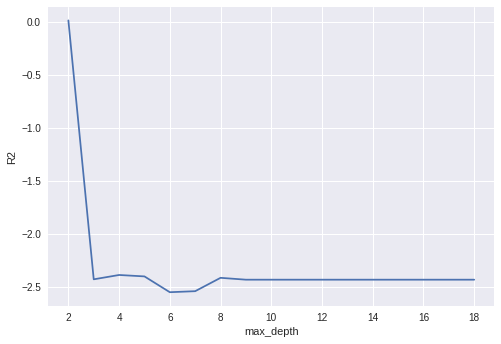

In [91]:
max_depth_range = list(range(2, 19)) # will try every value between 2 and 19
# List to store the score for each value of max_depth:
r2 = []
for depth in max_depth_range:
    dec_tree = DecisionTreeRegressor(max_depth = depth, 
                             random_state = 42)
    dec_tree_pipe = make_pipeline(col_trans, dec_tree)
    dec_tree_pipe.fit(X_train, y_train)
    score = dec_tree_pipe.score(X_test, y_test)
    r2.append(score)
plt.plot(max_depth_range, r2)
plt.xlabel('max_depth')
plt.ylabel('R2');

In [92]:
reg_tree = DecisionTreeRegressor(max_depth = 2, random_state = 42)
reg_tree_pipe = make_pipeline(col_trans, reg_tree)
reg_tree_pipe.fit(X_train, y_train)
print('Regression Tree R^2 Training Score:', r2_score(y_train, reg_tree_pipe.predict(X_train)))
print('Regression Tree R^2 Testing Score:', r2_score(y_test, reg_tree_pipe.predict(X_test)))
print('Regression Tree RMSE Training:', np.sqrt(mean_squared_error(y_train, reg_tree_pipe.predict(X_train))))
print('Regression Tree RMSE Testing:', np.sqrt(mean_squared_error(y_test, reg_tree_pipe.predict(X_test))))

Regression Tree R^2 Training Score: 0.451180261462087
Regression Tree R^2 Testing Score: 0.011434116100958569
Regression Tree RMSE Training: 31.81310821013585
Regression Tree RMSE Testing: 45.251201686719526


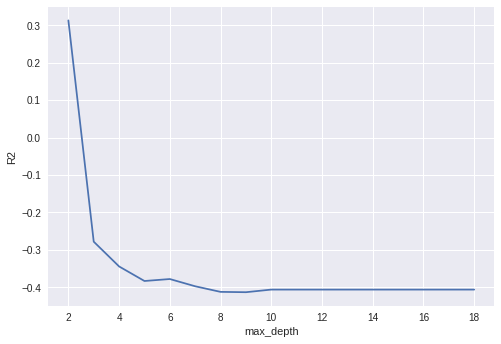

In [93]:
max_depth_range = list(range(2, 19)) # will try every value between 2 and 19
# List to store the score for each value of max_depth:
r2 = []
for depth in max_depth_range:
    rf = RandomForestRegressor(max_depth = depth, 
                             random_state = 42)
    rf_pipe = make_pipeline(col_trans, rf)
    rf_pipe.fit(X_train, y_train)
    score = rf_pipe.score(X_test, y_test)
    r2.append(score)
plt.plot(max_depth_range, r2)
plt.xlabel('max_depth')
plt.ylabel('R2');

In [94]:
mrf = RandomForestRegressor(max_depth = 2, random_state=42)
rf_pipe = make_pipeline(col_trans, rf)
rf_pipe.fit(X_train, y_train)
print('Random Forest Training R^2 Scores:', r2_score(y_train, rf_pipe.predict(X_train)))
print('Random Forest Testing R^2 Scores:', r2_score(y_test, rf_pipe.predict(X_test)))
print('Random Forests RMSE Training:', np.sqrt(mean_squared_error(y_train, rf_pipe.predict(X_train))))
print('Random Forests RMSE Testing:', np.sqrt(mean_squared_error(y_test, rf_pipe.predict(X_test))))

Random Forest Training R^2 Scores: 0.8512986166128345
Random Forest Testing R^2 Scores: -0.4059134303406562
Random Forests RMSE Training: 16.55955819887522
Random Forests RMSE Testing: 53.96430613251352


## Conclusion

The data we have does not reliably predict values for test data. RMSE Testing is ~ 45-53 minutes off from true value, and the negative R^2 indicates it performs worse than a baseline (horizontal line across average of the target value). The R^2 for our Logistic Regression model is positive, but its performance on testing data is about 1%.

It is safe to say we do not have enough features to reliably predict how much time a student will need during their TA request sessions.

# Overall Conclusion

This dataset would need more information/columns (features) in order to build a true and reliable machine learning model.

This data set is much better suited for data analysis/EDA.